## 训练目标

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

> ◆D(x)输出是否是真实图像, Prob  
> ◆训练判别器,就是使V(D,G)变大，**真图判对，假图判错的Prob**  
> ◆训练生成器,就是使V(D,G)变小，**假图判错的Prob**

### 反卷积
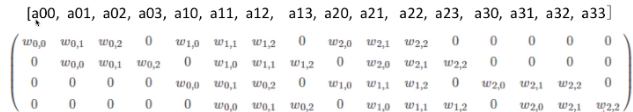
b = (w) * [a]T

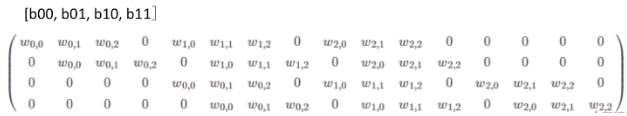
a = (w)T * b

## Code


1. Data provider:  
    a. Imgae data  
    b. random vector(generate a random image)  
2. Build computer graph:  
    a. generator  
    b. discriminator  
    c. DCGAN  
        connect g and d
        define loss
        define train_op
3. trianing process  


In [2]:
import os
import sys
import tensorflow as tf
from tensorflow import logging
from tensorflow import gfile
import pprint
import numpy as np
import random
import math
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./rnn_DCGAN/MNIST_data/', one_hot=True)

output_dir = './rnn_DCGAN/local_run'
if not gfile.Exists(output_dir):
    gfile.MakeDirs(output_dir)


def get_default_params():
    return tf.contrib.training.HParams(
        z_dim=100,  # random vector size
        init_conv_size=4,  # 反卷积初始特征图大小
        g_channels=[128, 64, 32, 1],   
        d_channels=[32, 64, 128, 256],  
        batch_size=128,
        learning_rate=0.002,
        beta1=0.5,  # Adam
        img_size=32, # 生成图片大小
    )


hps = get_default_params()

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./rnn_DCGAN/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./rnn_DCGAN/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./rnn_DCGAN/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./rnn_DCGAN/MNIST_data/t10k-labels-idx1-ubyte.gz


### 图片数据处理

In [2]:
class MnistData(object):
    def __init__(self, mnist_train, z_dim, img_size):
        self._data = mnist_train
        self._example_num = len(self._data)
        self._z_data = np.random.standard_normal((self._example_num, z_dim))
        self._indicator = 0
        self._resize_mnist_img(img_size)
        self._random_shuffle()
    
    def _random_shuffle(self):
        p = np.random.permutation(self._example_num)
        self._z_data = self._z_data[p]
        self._data = self._data[p]
    
    def _resize_mnist_img(self, img_size):
        """Resize mnist image to img_size"""
        data = np.asarray(self._data * 255, np.uint8)
        data = data.reshape((self._example_num, 1, 28, 28))
        data = data.transpose((0, 2, 3, 1))
        new_data = []
        for i in range(self._example_num):
            img = data[i].reshape((28, 28))
            img = Image.fromarray(img)
            img = img.resize((img_size, img_size))
            img = np.asarray(img)
            img = img.reshape((img_size, img_size, 1))
            new_data.append(img)
        new_data = np.asarray(new_data, dtype=np.float32)
        new_data = new_data / 127.5 - 1
        self._data = new_data
        
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self._example_num:
            self._random_shuffle()
            # 重置
            self._indicator = 0
            end_indicator = self._indicator + batch_size
        assert end_indicator < self._example_num
        
        batch_data = self._data[self._indicator: end_indicator]
        batch_z = self._z_data[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_data, batch_z

mnist_data = MnistData(mnist.train.images, hps.z_dim, hps.img_size)
batch_data, batch_z = mnist_data.next_batch(5)
print(batch_data.shape)
print(batch_z.shape)

(5, 32, 32, 1)
(5, 100)


### 定义G and D

In [3]:
def conv2d_transpose(inputs, out_channel, name, training, with_bn_relu=True):
    """反卷积。注意最后一层需要激活层和BN，只需要tanh转换到（-1，1）"""
    with tf.variable_scope(name):
        conv2d_trans = tf.layers.conv2d_transpose(
            inputs, out_channel, [5, 5], strides=(2, 2), padding='SAME')
        if with_bn_relu:
            bn = tf.layers.batch_normalization(conv2d_trans, training=training)
            relu = tf.nn.relu(bn)
            return relu
        else:
            return conv2d_trans


def conv2d(inputs, out_channel, name, training):
    """判别器卷积"""
    def leaky_relu(x, leak=0.2, name=''):
        return tf.maximum(x, x * leak, name=name)

    with tf.variable_scope(name):
        conv2d_output = tf.layers.conv2d(
            inputs, out_channel, [5, 5], strides=(2, 2), padding='SAME')
        bn = tf.layers.batch_normalization(conv2d_output, training=training)
        return leaky_relu(bn, name='outputs')


class Generator(object):
    """Generator of GAN"""
    def __init__(self, channels, init_conv_size):
        assert len(channels) > 1
        self._channels = channels
        self._init_conv_size = init_conv_size
        self._reuse = False   # 训练时，需要重用，改为True

    def __call__(self, inputs, training):
        inputs = tf.convert_to_tensor(inputs)
        with tf.variable_scope('generator', reuse=self._reuse):
            """
            random vector > fc > channel * init_conv_size**2 > reshape > 
            [init_conv_size, init_conv_size, channel]
            """
            with tf.variable_scope('inputs'):
                fc = tf.layers.dense(
                    inputs, self._channels[0] * self._init_conv_size *
                    self._init_conv_size)
                conv0 = tf.reshape(fc, [
                    -1, self._init_conv_size, self._init_conv_size,
                    self._channels[0]
                ])
                bn0 = tf.layers.batch_normalization(conv0, training=training)
                relu0 = tf.nn.relu(bn0)

            deconv_inputs = relu0
            # deconvolutions * 4
            for i in range(1, len(self._channels)):
                # 最后一层不需要bn relu
                with_bn_relu = (i != len(self._channels) - 1)
                deconv_inputs = conv2d_transpose(
                    deconv_inputs, self._channels[i], 'deconv-%d' % i,
                    training, with_bn_relu)
            # generator输出
            img_inputs = deconv_inputs
            with tf.variable_scope('generate_imgs'):
                # imgs value scope: [-1, 1]
                imgs = tf.tanh(img_inputs, name='imgaes')
        self._reuse = True
        
        # 保存生成器的所有参数（生成器和判别器是分开训练的，变量分开存储）
        # tf.get_collection获得某个scope下的所有参数
        self.variables = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        return imgs


class Discriminator(object):
    """Discriminator of GAN"""
    def __init__(self, channels):
        self._channels = channels
        self._reuse = False

    def __call__(self, inputs, training):
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)

        conv_inputs = inputs
        with tf.variable_scope('discriminator', reuse=self._reuse):
            for i in range(len(self._channels)):
                conv_inputs = conv2d(conv_inputs, self._channels[i],
                                     'deconv-%d' % i, training)
            fc_inputs = conv_inputs
            with tf.variable_scope('fc'):
                flatten = tf.contrib.layers.flatten(fc_inputs)
                logits = tf.layers.dense(flatten, 2, name="logits")
        self._reuse = True
        self.variables = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        return logits

### DCGAN

In [4]:
class DCGAN(object):
    """DCGAN implementation."""
    def __init__(self, hps):
        g_channels = hps.g_channels
        d_channels = hps.d_channels
        
        self._batch_size = hps.batch_size
        self._init_conv_size = hps.init_conv_size
        self._batch_size = hps.batch_size
        self._z_dim = hps.z_dim
        self._img_size = hps.img_size

        self._generator = Generator(g_channels, self._init_conv_size)
        self._discriminator = Discriminator(d_channels)

    def build(self):
        """Build compute graph."""
        # 初始随机变量placeholder
        self._z_placholder = tf.placeholder(tf.float32,
                                            (self._batch_size, self._z_dim))
        # 真实图像
        self._img_placeholder = tf.placeholder(
            tf.float32, (self._batch_size, self._img_size, self._img_size, 1))

        generated_imgs = self._generator(
            self._z_placholder, training=True)
        fake_img_logits = self._discriminator(
            generated_imgs, training=True)
        real_img_logits = self._discriminator(
            self._img_placeholder, training=True)

        loss_on_fake_to_real = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=tf.ones([self._batch_size], dtype=tf.int64),
                logits=fake_img_logits))    # 1，训练G
        loss_on_fake_to_fake = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=tf.zeros([self._batch_size], dtype=tf.int64),
                logits=fake_img_logits))    # 0， 训练D
        loss_on_real_to_real = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=tf.ones([self._batch_size], dtype=tf.int64),
                logits=real_img_logits))    # 1， 训练D

        # 相当于字典
        tf.add_to_collection('g_losses', loss_on_fake_to_real)
        tf.add_to_collection('d_losses', loss_on_fake_to_fake)
        tf.add_to_collection('d_losses', loss_on_real_to_real)

        loss = {
            'g': tf.add_n(tf.get_collection('g_losses'), name='total_g_loss'),
            'd': tf.add_n(tf.get_collection('d_losses'), name='total_d_loss')
        }

        return (self._z_placholder, self._img_placeholder, generated_imgs,
                loss)

    def build_train(self, losses, learning_rate, beta1):
        """Build train op."""
        g_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1)
        d_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1)
        
        g_opt_op = g_opt.minimize(
            losses['g'], var_list=self._generator.variables)
        d_opt_op = d_opt.minimize(
            losses['d'], var_list=self._discriminator.variables)
        with tf.control_dependencies(control_inputs=[g_opt_op, d_opt_op]):
            # control_inputs: A list of `Operation` or `Tensor` objects which
            # must be executed or computed before running the operations
            # defined in the context.
            # 执行顺序：g_opt_op > d_opt_op > g_opt_op ...
            return tf.no_op(name='train')


dcgan = DCGAN(hps)
z_placeholder, img_placeholder, generated_imgs, losses = dcgan.build()
train_op = dcgan.build_train(losses, hps.learning_rate, hps.beta1)

### Training

In [3]:
def combine_and_show_imgs(batch_imgs, img_size, rows=8, cols=16):
    """Combine small images in a batch into a big pic."""
    # batch_imgs: [batch_size, img_size, img_size, 1]
    result_big_img = []
    for i in range(rows):
        row_imgs = []
        for j in range(cols):
            img = batch_imgs[cols * i + j]
            img = img.reshape((img_size, img_size))
            img = (img + 1) * 127.5
            row_imgs.append(img)    # 注意不要append自身。。
        row_imgs = np.hstack(row_imgs)
        result_big_img.append(row_imgs)
    result_big_img = np.vstack(result_big_img)
    result_big_img = np.asarray(result_big_img, np.uint8)
    result_big_img = Image.fromarray(result_big_img)
    return result_big_img

In [5]:
init_op = tf.global_variables_initializer()
train_steps = 10000

with tf.Session() as sess:
    sess.run(init_op)
    for step in range(train_steps):
        batch_img, batch_z = mnist_data.next_batch(hps.batch_size)

        fetches = [train_op, losses['g'], losses['d']]
        should_sample = (step + 1) % 50 == 0
        
        if should_sample:
            fetches += [generated_imgs]
        
        out_values = sess.run(
            fetches,
            feed_dict={
                z_placeholder: batch_z,
                img_placeholder: batch_img
            })
        _, g_loss_val, d_loss_val = out_values[0:3]
        logging.info('step: %d, g_loss: %4.3f, d_loss: %4.3f' %
                     (step, g_loss_val, d_loss_val))
        if should_sample:
            gen_imgs_val = out_values[3]
            
            # generated image
            gen_img_path = os.path.join(output_dir,
                                        '%05d-gen.jpg' % (step + 1))
            # groud truth
            gt_img_path = os.path.join(output_dir, '%05d-gt.jpg' % (step + 1))

            gen_img = combine_and_show_imgs(gen_imgs_val, hps.img_size)
            gt_img = combine_and_show_imgs(batch_img, hps.img_size)

            gen_img.save(gen_img_path)
            gt_img.save(gt_img_path)

INFO:tensorflow:step: 0, g_loss: 0.484, d_loss: 1.984
INFO:tensorflow:step: 1, g_loss: 17.201, d_loss: 0.004
INFO:tensorflow:step: 2, g_loss: 0.001, d_loss: 10.027
INFO:tensorflow:step: 3, g_loss: 26.140, d_loss: 10.231
INFO:tensorflow:step: 4, g_loss: 23.698, d_loss: 0.002
INFO:tensorflow:step: 5, g_loss: 20.158, d_loss: 0.002
INFO:tensorflow:step: 6, g_loss: 3.154, d_loss: 0.258
INFO:tensorflow:step: 7, g_loss: 0.000, d_loss: 14.111
INFO:tensorflow:step: 8, g_loss: 7.200, d_loss: 0.062
INFO:tensorflow:step: 9, g_loss: 2.901, d_loss: 0.302
INFO:tensorflow:step: 10, g_loss: 0.932, d_loss: 1.004
INFO:tensorflow:step: 11, g_loss: 4.873, d_loss: 1.323
INFO:tensorflow:step: 12, g_loss: 0.069, d_loss: 2.826
INFO:tensorflow:step: 13, g_loss: 7.676, d_loss: 0.895
INFO:tensorflow:step: 14, g_loss: 6.785, d_loss: 0.201
INFO:tensorflow:step: 15, g_loss: 3.703, d_loss: 0.064
INFO:tensorflow:step: 16, g_loss: 0.143, d_loss: 2.075
INFO:tensorflow:step: 17, g_loss: 8.911, d_loss: 1.115
INFO:tensorfl

INFO:tensorflow:step: 149, g_loss: 0.813, d_loss: 0.693
INFO:tensorflow:step: 150, g_loss: 2.947, d_loss: 0.395
INFO:tensorflow:step: 151, g_loss: 2.015, d_loss: 0.395
INFO:tensorflow:step: 152, g_loss: 1.063, d_loss: 0.647
INFO:tensorflow:step: 153, g_loss: 5.637, d_loss: 0.584
INFO:tensorflow:step: 154, g_loss: 4.144, d_loss: 0.108
INFO:tensorflow:step: 155, g_loss: 0.969, d_loss: 0.675
INFO:tensorflow:step: 156, g_loss: 6.413, d_loss: 0.625
INFO:tensorflow:step: 157, g_loss: 4.112, d_loss: 0.181
INFO:tensorflow:step: 158, g_loss: 0.528, d_loss: 1.052
INFO:tensorflow:step: 159, g_loss: 6.665, d_loss: 1.038
INFO:tensorflow:step: 160, g_loss: 3.106, d_loss: 0.123
INFO:tensorflow:step: 161, g_loss: 0.996, d_loss: 0.637
INFO:tensorflow:step: 162, g_loss: 4.827, d_loss: 0.150
INFO:tensorflow:step: 163, g_loss: 3.309, d_loss: 0.171
INFO:tensorflow:step: 164, g_loss: 0.868, d_loss: 0.898
INFO:tensorflow:step: 165, g_loss: 6.401, d_loss: 1.194
INFO:tensorflow:step: 166, g_loss: 2.852, d_loss

INFO:tensorflow:step: 296, g_loss: 1.498, d_loss: 0.600
INFO:tensorflow:step: 297, g_loss: 1.789, d_loss: 0.439
INFO:tensorflow:step: 298, g_loss: 1.959, d_loss: 0.419
INFO:tensorflow:step: 299, g_loss: 1.355, d_loss: 0.758
INFO:tensorflow:step: 300, g_loss: 2.088, d_loss: 0.726
INFO:tensorflow:step: 301, g_loss: 0.477, d_loss: 1.467
INFO:tensorflow:step: 302, g_loss: 9.642, d_loss: 3.816
INFO:tensorflow:step: 303, g_loss: 5.327, d_loss: 0.252
INFO:tensorflow:step: 304, g_loss: 1.075, d_loss: 0.868
INFO:tensorflow:step: 305, g_loss: 2.754, d_loss: 0.160
INFO:tensorflow:step: 306, g_loss: 1.920, d_loss: 0.429
INFO:tensorflow:step: 307, g_loss: 1.962, d_loss: 0.769
INFO:tensorflow:step: 308, g_loss: 1.204, d_loss: 0.941
INFO:tensorflow:step: 309, g_loss: 2.688, d_loss: 0.847
INFO:tensorflow:step: 310, g_loss: 0.867, d_loss: 0.849
INFO:tensorflow:step: 311, g_loss: 4.605, d_loss: 0.452
INFO:tensorflow:step: 312, g_loss: 3.352, d_loss: 0.167
INFO:tensorflow:step: 313, g_loss: 1.350, d_loss

INFO:tensorflow:step: 443, g_loss: 5.811, d_loss: 0.530
INFO:tensorflow:step: 444, g_loss: 1.322, d_loss: 0.516
INFO:tensorflow:step: 445, g_loss: 0.919, d_loss: 0.804
INFO:tensorflow:step: 446, g_loss: 5.545, d_loss: 1.982
INFO:tensorflow:step: 447, g_loss: 0.822, d_loss: 0.810
INFO:tensorflow:step: 448, g_loss: 3.028, d_loss: 0.430
INFO:tensorflow:step: 449, g_loss: 2.866, d_loss: 0.253
INFO:tensorflow:step: 450, g_loss: 1.054, d_loss: 0.670
INFO:tensorflow:step: 451, g_loss: 4.187, d_loss: 0.867
INFO:tensorflow:step: 452, g_loss: 0.722, d_loss: 0.989
INFO:tensorflow:step: 453, g_loss: 3.553, d_loss: 0.767
INFO:tensorflow:step: 454, g_loss: 1.601, d_loss: 0.501
INFO:tensorflow:step: 455, g_loss: 0.855, d_loss: 0.918
INFO:tensorflow:step: 456, g_loss: 3.746, d_loss: 1.021
INFO:tensorflow:step: 457, g_loss: 1.034, d_loss: 0.695
INFO:tensorflow:step: 458, g_loss: 1.919, d_loss: 0.385
INFO:tensorflow:step: 459, g_loss: 2.626, d_loss: 0.485
INFO:tensorflow:step: 460, g_loss: 1.400, d_loss

INFO:tensorflow:step: 590, g_loss: 4.110, d_loss: 1.831
INFO:tensorflow:step: 591, g_loss: 0.445, d_loss: 1.362
INFO:tensorflow:step: 592, g_loss: 3.548, d_loss: 0.593
INFO:tensorflow:step: 593, g_loss: 3.393, d_loss: 0.323
INFO:tensorflow:step: 594, g_loss: 1.107, d_loss: 0.687
INFO:tensorflow:step: 595, g_loss: 2.371, d_loss: 0.446
INFO:tensorflow:step: 596, g_loss: 1.613, d_loss: 0.553
INFO:tensorflow:step: 597, g_loss: 2.358, d_loss: 0.719
INFO:tensorflow:step: 598, g_loss: 0.483, d_loss: 1.195
INFO:tensorflow:step: 599, g_loss: 3.738, d_loss: 0.783
INFO:tensorflow:step: 600, g_loss: 2.211, d_loss: 0.379
INFO:tensorflow:step: 601, g_loss: 0.830, d_loss: 0.858
INFO:tensorflow:step: 602, g_loss: 3.350, d_loss: 0.820
INFO:tensorflow:step: 603, g_loss: 0.702, d_loss: 1.060
INFO:tensorflow:step: 604, g_loss: 4.162, d_loss: 1.591
INFO:tensorflow:step: 605, g_loss: 0.693, d_loss: 1.084
INFO:tensorflow:step: 606, g_loss: 2.876, d_loss: 0.573
INFO:tensorflow:step: 607, g_loss: 2.233, d_loss

INFO:tensorflow:step: 883, g_loss: 1.356, d_loss: 0.641
INFO:tensorflow:step: 884, g_loss: 2.857, d_loss: 0.525
INFO:tensorflow:step: 885, g_loss: 0.969, d_loss: 0.853
INFO:tensorflow:step: 886, g_loss: 2.572, d_loss: 0.589
INFO:tensorflow:step: 887, g_loss: 1.839, d_loss: 0.522
INFO:tensorflow:step: 888, g_loss: 1.121, d_loss: 0.787
INFO:tensorflow:step: 889, g_loss: 3.037, d_loss: 0.786
INFO:tensorflow:step: 890, g_loss: 0.549, d_loss: 1.693
INFO:tensorflow:step: 891, g_loss: 4.828, d_loss: 1.265
INFO:tensorflow:step: 892, g_loss: 0.926, d_loss: 0.830
INFO:tensorflow:step: 893, g_loss: 2.602, d_loss: 0.380
INFO:tensorflow:step: 894, g_loss: 2.918, d_loss: 0.512
INFO:tensorflow:step: 895, g_loss: 0.959, d_loss: 0.685
INFO:tensorflow:step: 896, g_loss: 2.478, d_loss: 0.437
INFO:tensorflow:step: 897, g_loss: 2.840, d_loss: 0.495
INFO:tensorflow:step: 898, g_loss: 0.757, d_loss: 0.866
INFO:tensorflow:step: 899, g_loss: 2.917, d_loss: 0.912
INFO:tensorflow:step: 900, g_loss: 1.043, d_loss

INFO:tensorflow:step: 1029, g_loss: 1.704, d_loss: 0.531
INFO:tensorflow:step: 1030, g_loss: 2.500, d_loss: 0.562
INFO:tensorflow:step: 1031, g_loss: 1.227, d_loss: 0.582
INFO:tensorflow:step: 1032, g_loss: 4.257, d_loss: 0.672
INFO:tensorflow:step: 1033, g_loss: 0.596, d_loss: 1.154
INFO:tensorflow:step: 1034, g_loss: 5.652, d_loss: 1.607
INFO:tensorflow:step: 1035, g_loss: 0.676, d_loss: 1.038
INFO:tensorflow:step: 1036, g_loss: 4.497, d_loss: 1.617
INFO:tensorflow:step: 1037, g_loss: 0.139, d_loss: 2.434
INFO:tensorflow:step: 1038, g_loss: 3.923, d_loss: 0.761
INFO:tensorflow:step: 1039, g_loss: 1.826, d_loss: 0.455
INFO:tensorflow:step: 1040, g_loss: 1.548, d_loss: 0.553
INFO:tensorflow:step: 1041, g_loss: 1.784, d_loss: 0.643
INFO:tensorflow:step: 1042, g_loss: 1.114, d_loss: 0.845
INFO:tensorflow:step: 1043, g_loss: 1.988, d_loss: 0.560
INFO:tensorflow:step: 1044, g_loss: 2.159, d_loss: 0.417
INFO:tensorflow:step: 1045, g_loss: 1.206, d_loss: 0.831
INFO:tensorflow:step: 1046, g_l

INFO:tensorflow:step: 1173, g_loss: 2.985, d_loss: 0.638
INFO:tensorflow:step: 1174, g_loss: 1.131, d_loss: 0.726
INFO:tensorflow:step: 1175, g_loss: 2.243, d_loss: 0.665
INFO:tensorflow:step: 1176, g_loss: 1.202, d_loss: 0.668
INFO:tensorflow:step: 1177, g_loss: 2.736, d_loss: 0.760
INFO:tensorflow:step: 1178, g_loss: 0.858, d_loss: 0.802
INFO:tensorflow:step: 1179, g_loss: 3.393, d_loss: 0.832
INFO:tensorflow:step: 1180, g_loss: 1.046, d_loss: 0.632
INFO:tensorflow:step: 1181, g_loss: 1.990, d_loss: 0.546
INFO:tensorflow:step: 1182, g_loss: 1.547, d_loss: 0.679
INFO:tensorflow:step: 1183, g_loss: 2.200, d_loss: 0.592
INFO:tensorflow:step: 1184, g_loss: 0.869, d_loss: 0.854
INFO:tensorflow:step: 1185, g_loss: 3.393, d_loss: 0.669
INFO:tensorflow:step: 1186, g_loss: 1.175, d_loss: 0.649
INFO:tensorflow:step: 1187, g_loss: 2.303, d_loss: 0.533
INFO:tensorflow:step: 1188, g_loss: 1.373, d_loss: 0.666
INFO:tensorflow:step: 1189, g_loss: 2.347, d_loss: 0.506
INFO:tensorflow:step: 1190, g_l

INFO:tensorflow:step: 1460, g_loss: 1.058, d_loss: 0.726
INFO:tensorflow:step: 1461, g_loss: 2.900, d_loss: 0.880
INFO:tensorflow:step: 1462, g_loss: 0.787, d_loss: 0.881
INFO:tensorflow:step: 1463, g_loss: 2.837, d_loss: 0.894
INFO:tensorflow:step: 1464, g_loss: 1.473, d_loss: 0.566
INFO:tensorflow:step: 1465, g_loss: 1.431, d_loss: 0.502
INFO:tensorflow:step: 1466, g_loss: 3.211, d_loss: 0.921
INFO:tensorflow:step: 1467, g_loss: 0.713, d_loss: 0.963
INFO:tensorflow:step: 1468, g_loss: 1.962, d_loss: 0.686
INFO:tensorflow:step: 1469, g_loss: 1.938, d_loss: 0.492
INFO:tensorflow:step: 1470, g_loss: 1.214, d_loss: 0.700
INFO:tensorflow:step: 1471, g_loss: 2.514, d_loss: 0.625
INFO:tensorflow:step: 1472, g_loss: 1.444, d_loss: 0.604
INFO:tensorflow:step: 1473, g_loss: 1.904, d_loss: 0.449
INFO:tensorflow:step: 1474, g_loss: 2.191, d_loss: 0.437
INFO:tensorflow:step: 1475, g_loss: 2.317, d_loss: 0.500
INFO:tensorflow:step: 1476, g_loss: 1.356, d_loss: 0.617
INFO:tensorflow:step: 1477, g_l

INFO:tensorflow:step: 1747, g_loss: 1.588, d_loss: 0.599
INFO:tensorflow:step: 1748, g_loss: 1.181, d_loss: 0.822
INFO:tensorflow:step: 1749, g_loss: 2.100, d_loss: 0.894
INFO:tensorflow:step: 1750, g_loss: 0.510, d_loss: 1.308
INFO:tensorflow:step: 1751, g_loss: 3.098, d_loss: 1.644
INFO:tensorflow:step: 1752, g_loss: 0.608, d_loss: 1.080
INFO:tensorflow:step: 1753, g_loss: 1.914, d_loss: 0.538
INFO:tensorflow:step: 1754, g_loss: 2.493, d_loss: 0.720
INFO:tensorflow:step: 1755, g_loss: 0.811, d_loss: 0.810
INFO:tensorflow:step: 1756, g_loss: 3.076, d_loss: 0.941
INFO:tensorflow:step: 1757, g_loss: 0.750, d_loss: 0.916
INFO:tensorflow:step: 1758, g_loss: 2.459, d_loss: 0.593
INFO:tensorflow:step: 1759, g_loss: 1.700, d_loss: 0.693
INFO:tensorflow:step: 1760, g_loss: 1.173, d_loss: 0.768
INFO:tensorflow:step: 1761, g_loss: 1.667, d_loss: 0.588
INFO:tensorflow:step: 1762, g_loss: 1.835, d_loss: 0.726
INFO:tensorflow:step: 1763, g_loss: 1.038, d_loss: 0.816
INFO:tensorflow:step: 1764, g_l

INFO:tensorflow:step: 1891, g_loss: 2.347, d_loss: 0.782
INFO:tensorflow:step: 1892, g_loss: 1.550, d_loss: 0.537
INFO:tensorflow:step: 1893, g_loss: 1.310, d_loss: 0.812
INFO:tensorflow:step: 1894, g_loss: 1.510, d_loss: 0.849
INFO:tensorflow:step: 1895, g_loss: 1.395, d_loss: 0.862
INFO:tensorflow:step: 1896, g_loss: 2.172, d_loss: 0.954
INFO:tensorflow:step: 1897, g_loss: 0.530, d_loss: 1.289
INFO:tensorflow:step: 1898, g_loss: 2.952, d_loss: 0.974
INFO:tensorflow:step: 1899, g_loss: 1.406, d_loss: 0.644
INFO:tensorflow:step: 1900, g_loss: 1.250, d_loss: 0.779
INFO:tensorflow:step: 1901, g_loss: 2.568, d_loss: 0.673
INFO:tensorflow:step: 1902, g_loss: 0.985, d_loss: 0.725
INFO:tensorflow:step: 1903, g_loss: 2.001, d_loss: 1.187
INFO:tensorflow:step: 1904, g_loss: 1.149, d_loss: 0.770
INFO:tensorflow:step: 1905, g_loss: 1.972, d_loss: 0.647
INFO:tensorflow:step: 1906, g_loss: 1.480, d_loss: 0.561
INFO:tensorflow:step: 1907, g_loss: 2.272, d_loss: 0.636
INFO:tensorflow:step: 1908, g_l

INFO:tensorflow:step: 2035, g_loss: 0.572, d_loss: 1.213
INFO:tensorflow:step: 2036, g_loss: 3.388, d_loss: 0.683
INFO:tensorflow:step: 2037, g_loss: 2.047, d_loss: 0.336
INFO:tensorflow:step: 2038, g_loss: 1.667, d_loss: 0.497
INFO:tensorflow:step: 2039, g_loss: 2.408, d_loss: 0.345
INFO:tensorflow:step: 2040, g_loss: 2.502, d_loss: 0.364
INFO:tensorflow:step: 2041, g_loss: 1.100, d_loss: 0.612
INFO:tensorflow:step: 2042, g_loss: 4.130, d_loss: 1.401
INFO:tensorflow:step: 2043, g_loss: 0.344, d_loss: 1.560
INFO:tensorflow:step: 2044, g_loss: 4.201, d_loss: 1.163
INFO:tensorflow:step: 2045, g_loss: 0.933, d_loss: 0.842
INFO:tensorflow:step: 2046, g_loss: 1.687, d_loss: 0.632
INFO:tensorflow:step: 2047, g_loss: 3.180, d_loss: 0.709
INFO:tensorflow:step: 2048, g_loss: 0.892, d_loss: 0.803
INFO:tensorflow:step: 2049, g_loss: 2.572, d_loss: 0.346
INFO:tensorflow:step: 2050, g_loss: 3.705, d_loss: 0.590
INFO:tensorflow:step: 2051, g_loss: 0.490, d_loss: 1.236
INFO:tensorflow:step: 2052, g_l

INFO:tensorflow:step: 2179, g_loss: 0.501, d_loss: 1.217
INFO:tensorflow:step: 2180, g_loss: 2.426, d_loss: 1.030
INFO:tensorflow:step: 2181, g_loss: 1.056, d_loss: 0.722
INFO:tensorflow:step: 2182, g_loss: 2.236, d_loss: 0.752
INFO:tensorflow:step: 2183, g_loss: 1.639, d_loss: 0.873
INFO:tensorflow:step: 2184, g_loss: 1.232, d_loss: 0.887
INFO:tensorflow:step: 2185, g_loss: 2.184, d_loss: 0.402
INFO:tensorflow:step: 2186, g_loss: 1.739, d_loss: 0.536
INFO:tensorflow:step: 2187, g_loss: 2.343, d_loss: 0.896
INFO:tensorflow:step: 2188, g_loss: 0.885, d_loss: 1.068
INFO:tensorflow:step: 2189, g_loss: 1.995, d_loss: 0.688
INFO:tensorflow:step: 2190, g_loss: 2.963, d_loss: 0.958
INFO:tensorflow:step: 2191, g_loss: 0.267, d_loss: 1.810
INFO:tensorflow:step: 2192, g_loss: 3.326, d_loss: 1.059
INFO:tensorflow:step: 2193, g_loss: 1.979, d_loss: 0.400
INFO:tensorflow:step: 2194, g_loss: 1.459, d_loss: 0.471
INFO:tensorflow:step: 2195, g_loss: 1.754, d_loss: 0.484
INFO:tensorflow:step: 2196, g_l

INFO:tensorflow:step: 2323, g_loss: 1.156, d_loss: 0.872
INFO:tensorflow:step: 2324, g_loss: 2.282, d_loss: 0.426
INFO:tensorflow:step: 2325, g_loss: 1.684, d_loss: 0.523
INFO:tensorflow:step: 2326, g_loss: 2.133, d_loss: 0.628
INFO:tensorflow:step: 2327, g_loss: 1.585, d_loss: 0.771
INFO:tensorflow:step: 2328, g_loss: 1.287, d_loss: 0.763
INFO:tensorflow:step: 2329, g_loss: 2.510, d_loss: 0.590
INFO:tensorflow:step: 2330, g_loss: 1.309, d_loss: 0.639
INFO:tensorflow:step: 2331, g_loss: 1.791, d_loss: 0.733
INFO:tensorflow:step: 2332, g_loss: 2.361, d_loss: 0.501
INFO:tensorflow:step: 2333, g_loss: 1.285, d_loss: 0.615
INFO:tensorflow:step: 2334, g_loss: 3.882, d_loss: 0.640
INFO:tensorflow:step: 2335, g_loss: 0.489, d_loss: 1.461
INFO:tensorflow:step: 2336, g_loss: 5.187, d_loss: 1.376
INFO:tensorflow:step: 2337, g_loss: 0.749, d_loss: 1.053
INFO:tensorflow:step: 2338, g_loss: 2.124, d_loss: 0.803
INFO:tensorflow:step: 2339, g_loss: 2.210, d_loss: 0.452
INFO:tensorflow:step: 2340, g_l

INFO:tensorflow:step: 2467, g_loss: 0.773, d_loss: 1.140
INFO:tensorflow:step: 2468, g_loss: 5.337, d_loss: 0.987
INFO:tensorflow:step: 2469, g_loss: 1.205, d_loss: 0.636
INFO:tensorflow:step: 2470, g_loss: 1.962, d_loss: 0.468
INFO:tensorflow:step: 2471, g_loss: 2.572, d_loss: 0.617
INFO:tensorflow:step: 2472, g_loss: 0.689, d_loss: 1.042
INFO:tensorflow:step: 2473, g_loss: 3.781, d_loss: 0.991
INFO:tensorflow:step: 2474, g_loss: 1.131, d_loss: 0.574
INFO:tensorflow:step: 2475, g_loss: 2.870, d_loss: 0.600
INFO:tensorflow:step: 2476, g_loss: 1.044, d_loss: 0.684
INFO:tensorflow:step: 2477, g_loss: 3.019, d_loss: 0.866
INFO:tensorflow:step: 2478, g_loss: 0.831, d_loss: 0.908
INFO:tensorflow:step: 2479, g_loss: 3.357, d_loss: 0.442
INFO:tensorflow:step: 2480, g_loss: 2.163, d_loss: 0.480
INFO:tensorflow:step: 2481, g_loss: 0.875, d_loss: 0.867
INFO:tensorflow:step: 2482, g_loss: 4.756, d_loss: 0.452
INFO:tensorflow:step: 2483, g_loss: 2.525, d_loss: 0.338
INFO:tensorflow:step: 2484, g_l

INFO:tensorflow:step: 2611, g_loss: 1.432, d_loss: 1.017
INFO:tensorflow:step: 2612, g_loss: 2.005, d_loss: 1.035
INFO:tensorflow:step: 2613, g_loss: 1.400, d_loss: 0.881
INFO:tensorflow:step: 2614, g_loss: 1.859, d_loss: 0.486
INFO:tensorflow:step: 2615, g_loss: 1.742, d_loss: 0.732
INFO:tensorflow:step: 2616, g_loss: 1.868, d_loss: 0.452
INFO:tensorflow:step: 2617, g_loss: 1.439, d_loss: 0.731
INFO:tensorflow:step: 2618, g_loss: 1.542, d_loss: 0.774
INFO:tensorflow:step: 2619, g_loss: 2.543, d_loss: 1.458
INFO:tensorflow:step: 2620, g_loss: 0.569, d_loss: 1.238
INFO:tensorflow:step: 2621, g_loss: 2.664, d_loss: 0.688
INFO:tensorflow:step: 2622, g_loss: 1.505, d_loss: 0.588
INFO:tensorflow:step: 2623, g_loss: 1.987, d_loss: 0.987
INFO:tensorflow:step: 2624, g_loss: 1.058, d_loss: 0.718
INFO:tensorflow:step: 2625, g_loss: 2.047, d_loss: 0.469
INFO:tensorflow:step: 2626, g_loss: 2.906, d_loss: 0.475
INFO:tensorflow:step: 2627, g_loss: 0.970, d_loss: 0.839
INFO:tensorflow:step: 2628, g_l

INFO:tensorflow:step: 2897, g_loss: 3.452, d_loss: 0.296
INFO:tensorflow:step: 2898, g_loss: 2.532, d_loss: 0.252
INFO:tensorflow:step: 2899, g_loss: 2.653, d_loss: 0.342
INFO:tensorflow:step: 2900, g_loss: 1.649, d_loss: 0.345
INFO:tensorflow:step: 2901, g_loss: 3.390, d_loss: 0.327
INFO:tensorflow:step: 2902, g_loss: 1.485, d_loss: 0.489
INFO:tensorflow:step: 2903, g_loss: 2.924, d_loss: 0.501
INFO:tensorflow:step: 2904, g_loss: 1.660, d_loss: 0.382
INFO:tensorflow:step: 2905, g_loss: 3.238, d_loss: 0.332
INFO:tensorflow:step: 2906, g_loss: 1.917, d_loss: 0.397
INFO:tensorflow:step: 2907, g_loss: 2.860, d_loss: 0.247
INFO:tensorflow:step: 2908, g_loss: 2.511, d_loss: 0.249
INFO:tensorflow:step: 2909, g_loss: 3.004, d_loss: 0.171
INFO:tensorflow:step: 2910, g_loss: 2.107, d_loss: 0.357
INFO:tensorflow:step: 2911, g_loss: 2.827, d_loss: 0.239
INFO:tensorflow:step: 2912, g_loss: 3.013, d_loss: 0.190
INFO:tensorflow:step: 2913, g_loss: 2.280, d_loss: 0.198
INFO:tensorflow:step: 2914, g_l

INFO:tensorflow:step: 3041, g_loss: 3.989, d_loss: 0.823
INFO:tensorflow:step: 3042, g_loss: 1.166, d_loss: 0.664
INFO:tensorflow:step: 3043, g_loss: 2.643, d_loss: 0.547
INFO:tensorflow:step: 3044, g_loss: 1.734, d_loss: 0.649
INFO:tensorflow:step: 3045, g_loss: 1.643, d_loss: 0.506
INFO:tensorflow:step: 3046, g_loss: 3.117, d_loss: 0.576
INFO:tensorflow:step: 3047, g_loss: 0.959, d_loss: 0.924
INFO:tensorflow:step: 3048, g_loss: 4.027, d_loss: 1.049
INFO:tensorflow:step: 3049, g_loss: 0.982, d_loss: 0.854
INFO:tensorflow:step: 3050, g_loss: 2.892, d_loss: 0.567
INFO:tensorflow:step: 3051, g_loss: 2.142, d_loss: 0.465
INFO:tensorflow:step: 3052, g_loss: 1.738, d_loss: 0.493
INFO:tensorflow:step: 3053, g_loss: 2.397, d_loss: 0.546
INFO:tensorflow:step: 3054, g_loss: 1.655, d_loss: 0.538
INFO:tensorflow:step: 3055, g_loss: 2.119, d_loss: 0.389
INFO:tensorflow:step: 3056, g_loss: 2.866, d_loss: 0.299
INFO:tensorflow:step: 3057, g_loss: 1.490, d_loss: 0.586
INFO:tensorflow:step: 3058, g_l

INFO:tensorflow:step: 3185, g_loss: 3.864, d_loss: 0.321
INFO:tensorflow:step: 3186, g_loss: 3.274, d_loss: 0.172
INFO:tensorflow:step: 3187, g_loss: 1.926, d_loss: 0.266
INFO:tensorflow:step: 3188, g_loss: 2.841, d_loss: 0.511
INFO:tensorflow:step: 3189, g_loss: 1.394, d_loss: 0.499
INFO:tensorflow:step: 3190, g_loss: 4.123, d_loss: 0.443
INFO:tensorflow:step: 3191, g_loss: 2.073, d_loss: 0.259
INFO:tensorflow:step: 3192, g_loss: 2.032, d_loss: 0.284
INFO:tensorflow:step: 3193, g_loss: 3.808, d_loss: 0.734
INFO:tensorflow:step: 3194, g_loss: 0.407, d_loss: 1.451
INFO:tensorflow:step: 3195, g_loss: 7.212, d_loss: 1.558
INFO:tensorflow:step: 3196, g_loss: 0.959, d_loss: 0.721
INFO:tensorflow:step: 3197, g_loss: 4.206, d_loss: 0.388
INFO:tensorflow:step: 3198, g_loss: 2.071, d_loss: 0.280
INFO:tensorflow:step: 3199, g_loss: 2.743, d_loss: 0.239
INFO:tensorflow:step: 3200, g_loss: 2.150, d_loss: 0.306
INFO:tensorflow:step: 3201, g_loss: 2.236, d_loss: 0.256
INFO:tensorflow:step: 3202, g_l

INFO:tensorflow:step: 3471, g_loss: 2.806, d_loss: 0.379
INFO:tensorflow:step: 3472, g_loss: 2.677, d_loss: 0.200
INFO:tensorflow:step: 3473, g_loss: 2.789, d_loss: 0.606
INFO:tensorflow:step: 3474, g_loss: 0.587, d_loss: 1.242
INFO:tensorflow:step: 3475, g_loss: 4.916, d_loss: 0.883
INFO:tensorflow:step: 3476, g_loss: 1.461, d_loss: 0.494
INFO:tensorflow:step: 3477, g_loss: 2.050, d_loss: 0.391
INFO:tensorflow:step: 3478, g_loss: 3.517, d_loss: 0.464
INFO:tensorflow:step: 3479, g_loss: 0.976, d_loss: 0.738
INFO:tensorflow:step: 3480, g_loss: 3.110, d_loss: 0.375
INFO:tensorflow:step: 3481, g_loss: 2.537, d_loss: 0.373
INFO:tensorflow:step: 3482, g_loss: 2.342, d_loss: 0.239
INFO:tensorflow:step: 3483, g_loss: 2.276, d_loss: 0.224
INFO:tensorflow:step: 3484, g_loss: 2.242, d_loss: 0.555
INFO:tensorflow:step: 3485, g_loss: 2.389, d_loss: 0.546
INFO:tensorflow:step: 3486, g_loss: 2.418, d_loss: 0.402
INFO:tensorflow:step: 3487, g_loss: 3.236, d_loss: 0.445
INFO:tensorflow:step: 3488, g_l

INFO:tensorflow:step: 3615, g_loss: 3.180, d_loss: 0.192
INFO:tensorflow:step: 3616, g_loss: 2.467, d_loss: 0.176
INFO:tensorflow:step: 3617, g_loss: 3.479, d_loss: 0.275
INFO:tensorflow:step: 3618, g_loss: 3.141, d_loss: 0.228
INFO:tensorflow:step: 3619, g_loss: 1.062, d_loss: 0.582
INFO:tensorflow:step: 3620, g_loss: 4.881, d_loss: 0.941
INFO:tensorflow:step: 3621, g_loss: 2.256, d_loss: 0.257
INFO:tensorflow:step: 3622, g_loss: 1.193, d_loss: 0.588
INFO:tensorflow:step: 3623, g_loss: 6.127, d_loss: 1.723
INFO:tensorflow:step: 3624, g_loss: 0.312, d_loss: 1.694
INFO:tensorflow:step: 3625, g_loss: 7.073, d_loss: 1.788
INFO:tensorflow:step: 3626, g_loss: 0.899, d_loss: 0.790
INFO:tensorflow:step: 3627, g_loss: 3.005, d_loss: 0.313
INFO:tensorflow:step: 3628, g_loss: 2.717, d_loss: 0.461
INFO:tensorflow:step: 3629, g_loss: 0.720, d_loss: 1.045
INFO:tensorflow:step: 3630, g_loss: 3.340, d_loss: 0.625
INFO:tensorflow:step: 3631, g_loss: 2.293, d_loss: 0.289
INFO:tensorflow:step: 3632, g_l

INFO:tensorflow:step: 3902, g_loss: 5.302, d_loss: 0.413
INFO:tensorflow:step: 3903, g_loss: 2.407, d_loss: 0.279
INFO:tensorflow:step: 3904, g_loss: 1.809, d_loss: 0.376
INFO:tensorflow:step: 3905, g_loss: 2.342, d_loss: 0.677
INFO:tensorflow:step: 3906, g_loss: 0.990, d_loss: 0.804
INFO:tensorflow:step: 3907, g_loss: 5.510, d_loss: 0.520
INFO:tensorflow:step: 3908, g_loss: 2.928, d_loss: 0.217
INFO:tensorflow:step: 3909, g_loss: 2.342, d_loss: 0.208
INFO:tensorflow:step: 3910, g_loss: 2.646, d_loss: 0.390
INFO:tensorflow:step: 3911, g_loss: 3.185, d_loss: 0.155
INFO:tensorflow:step: 3912, g_loss: 2.506, d_loss: 0.217
INFO:tensorflow:step: 3913, g_loss: 2.372, d_loss: 0.278
INFO:tensorflow:step: 3914, g_loss: 4.852, d_loss: 0.183
INFO:tensorflow:step: 3915, g_loss: 2.066, d_loss: 0.255
INFO:tensorflow:step: 3916, g_loss: 3.233, d_loss: 0.290
INFO:tensorflow:step: 3917, g_loss: 2.659, d_loss: 0.293
INFO:tensorflow:step: 3918, g_loss: 2.919, d_loss: 0.119
INFO:tensorflow:step: 3919, g_l

INFO:tensorflow:step: 4046, g_loss: 4.427, d_loss: 0.676
INFO:tensorflow:step: 4047, g_loss: 1.603, d_loss: 0.366
INFO:tensorflow:step: 4048, g_loss: 2.646, d_loss: 0.186
INFO:tensorflow:step: 4049, g_loss: 3.277, d_loss: 0.379
INFO:tensorflow:step: 4050, g_loss: 0.894, d_loss: 0.812
INFO:tensorflow:step: 4051, g_loss: 5.109, d_loss: 1.521
INFO:tensorflow:step: 4052, g_loss: 1.334, d_loss: 0.543
INFO:tensorflow:step: 4053, g_loss: 3.393, d_loss: 0.347
INFO:tensorflow:step: 4054, g_loss: 2.225, d_loss: 0.322
INFO:tensorflow:step: 4055, g_loss: 3.034, d_loss: 0.324
INFO:tensorflow:step: 4056, g_loss: 1.710, d_loss: 0.345
INFO:tensorflow:step: 4057, g_loss: 3.084, d_loss: 0.266
INFO:tensorflow:step: 4058, g_loss: 4.318, d_loss: 0.297
INFO:tensorflow:step: 4059, g_loss: 1.728, d_loss: 0.330
INFO:tensorflow:step: 4060, g_loss: 2.677, d_loss: 0.156
INFO:tensorflow:step: 4061, g_loss: 3.064, d_loss: 0.378
INFO:tensorflow:step: 4062, g_loss: 1.770, d_loss: 0.445
INFO:tensorflow:step: 4063, g_l

INFO:tensorflow:step: 4333, g_loss: 2.255, d_loss: 0.539
INFO:tensorflow:step: 4334, g_loss: 2.245, d_loss: 0.328
INFO:tensorflow:step: 4335, g_loss: 3.156, d_loss: 0.227
INFO:tensorflow:step: 4336, g_loss: 1.637, d_loss: 0.445
INFO:tensorflow:step: 4337, g_loss: 3.477, d_loss: 0.473
INFO:tensorflow:step: 4338, g_loss: 1.207, d_loss: 0.607
INFO:tensorflow:step: 4339, g_loss: 2.869, d_loss: 0.185
INFO:tensorflow:step: 4340, g_loss: 3.324, d_loss: 0.726
INFO:tensorflow:step: 4341, g_loss: 0.400, d_loss: 1.485
INFO:tensorflow:step: 4342, g_loss: 6.178, d_loss: 1.343
INFO:tensorflow:step: 4343, g_loss: 2.440, d_loss: 0.193
INFO:tensorflow:step: 4344, g_loss: 1.760, d_loss: 0.356
INFO:tensorflow:step: 4345, g_loss: 2.977, d_loss: 0.280
INFO:tensorflow:step: 4346, g_loss: 2.908, d_loss: 0.297
INFO:tensorflow:step: 4347, g_loss: 1.976, d_loss: 0.353
INFO:tensorflow:step: 4348, g_loss: 4.017, d_loss: 0.193
INFO:tensorflow:step: 4349, g_loss: 1.801, d_loss: 0.430
INFO:tensorflow:step: 4350, g_l

INFO:tensorflow:step: 4477, g_loss: 6.547, d_loss: 0.735
INFO:tensorflow:step: 4478, g_loss: 2.158, d_loss: 0.235
INFO:tensorflow:step: 4479, g_loss: 1.655, d_loss: 0.442
INFO:tensorflow:step: 4480, g_loss: 7.702, d_loss: 1.656
INFO:tensorflow:step: 4481, g_loss: 0.268, d_loss: 2.357
INFO:tensorflow:step: 4482, g_loss: 11.042, d_loss: 5.320
INFO:tensorflow:step: 4483, g_loss: 0.569, d_loss: 1.870
INFO:tensorflow:step: 4484, g_loss: 3.789, d_loss: 0.338
INFO:tensorflow:step: 4485, g_loss: 3.209, d_loss: 0.607
INFO:tensorflow:step: 4486, g_loss: 0.650, d_loss: 1.127
INFO:tensorflow:step: 4487, g_loss: 4.678, d_loss: 0.830
INFO:tensorflow:step: 4488, g_loss: 1.591, d_loss: 0.598
INFO:tensorflow:step: 4489, g_loss: 2.224, d_loss: 0.390
INFO:tensorflow:step: 4490, g_loss: 2.379, d_loss: 0.576
INFO:tensorflow:step: 4491, g_loss: 2.655, d_loss: 0.304
INFO:tensorflow:step: 4492, g_loss: 3.123, d_loss: 0.205
INFO:tensorflow:step: 4493, g_loss: 2.920, d_loss: 0.197
INFO:tensorflow:step: 4494, g_

INFO:tensorflow:step: 4764, g_loss: 4.606, d_loss: 0.427
INFO:tensorflow:step: 4765, g_loss: 2.285, d_loss: 0.264
INFO:tensorflow:step: 4766, g_loss: 3.595, d_loss: 0.191
INFO:tensorflow:step: 4767, g_loss: 3.070, d_loss: 0.177
INFO:tensorflow:step: 4768, g_loss: 3.333, d_loss: 0.107
INFO:tensorflow:step: 4769, g_loss: 3.463, d_loss: 0.123
INFO:tensorflow:step: 4770, g_loss: 3.120, d_loss: 0.182
INFO:tensorflow:step: 4771, g_loss: 2.035, d_loss: 0.304
INFO:tensorflow:step: 4772, g_loss: 5.476, d_loss: 0.613
INFO:tensorflow:step: 4773, g_loss: 0.802, d_loss: 1.049
INFO:tensorflow:step: 4774, g_loss: 4.816, d_loss: 0.849
INFO:tensorflow:step: 4775, g_loss: 2.340, d_loss: 0.300
INFO:tensorflow:step: 4776, g_loss: 1.872, d_loss: 0.381
INFO:tensorflow:step: 4777, g_loss: 5.061, d_loss: 0.271
INFO:tensorflow:step: 4778, g_loss: 2.573, d_loss: 0.609
INFO:tensorflow:step: 4779, g_loss: 1.585, d_loss: 0.471
INFO:tensorflow:step: 4780, g_loss: 4.242, d_loss: 0.210
INFO:tensorflow:step: 4781, g_l

INFO:tensorflow:step: 4908, g_loss: 4.142, d_loss: 0.223
INFO:tensorflow:step: 4909, g_loss: 3.237, d_loss: 0.125
INFO:tensorflow:step: 4910, g_loss: 4.608, d_loss: 0.063
INFO:tensorflow:step: 4911, g_loss: 3.213, d_loss: 0.188
INFO:tensorflow:step: 4912, g_loss: 3.226, d_loss: 0.155
INFO:tensorflow:step: 4913, g_loss: 3.347, d_loss: 0.089
INFO:tensorflow:step: 4914, g_loss: 2.682, d_loss: 0.151
INFO:tensorflow:step: 4915, g_loss: 4.550, d_loss: 0.180
INFO:tensorflow:step: 4916, g_loss: 3.213, d_loss: 0.129
INFO:tensorflow:step: 4917, g_loss: 1.662, d_loss: 0.344
INFO:tensorflow:step: 4918, g_loss: 6.525, d_loss: 0.415
INFO:tensorflow:step: 4919, g_loss: 3.479, d_loss: 0.127
INFO:tensorflow:step: 4920, g_loss: 0.944, d_loss: 0.741
INFO:tensorflow:step: 4921, g_loss: 7.510, d_loss: 0.978
INFO:tensorflow:step: 4922, g_loss: 3.148, d_loss: 0.145
INFO:tensorflow:step: 4923, g_loss: 2.243, d_loss: 0.257
INFO:tensorflow:step: 4924, g_loss: 3.762, d_loss: 0.100
INFO:tensorflow:step: 4925, g_l

INFO:tensorflow:step: 5052, g_loss: 3.156, d_loss: 0.306
INFO:tensorflow:step: 5053, g_loss: 2.147, d_loss: 0.225
INFO:tensorflow:step: 5054, g_loss: 2.735, d_loss: 0.193
INFO:tensorflow:step: 5055, g_loss: 2.967, d_loss: 0.184
INFO:tensorflow:step: 5056, g_loss: 4.038, d_loss: 0.130
INFO:tensorflow:step: 5057, g_loss: 2.713, d_loss: 0.228
INFO:tensorflow:step: 5058, g_loss: 4.024, d_loss: 0.079
INFO:tensorflow:step: 5059, g_loss: 2.205, d_loss: 0.235
INFO:tensorflow:step: 5060, g_loss: 4.008, d_loss: 0.146
INFO:tensorflow:step: 5061, g_loss: 5.069, d_loss: 0.125
INFO:tensorflow:step: 5062, g_loss: 2.239, d_loss: 0.230
INFO:tensorflow:step: 5063, g_loss: 3.042, d_loss: 0.135
INFO:tensorflow:step: 5064, g_loss: 4.324, d_loss: 0.068
INFO:tensorflow:step: 5065, g_loss: 3.483, d_loss: 0.122
INFO:tensorflow:step: 5066, g_loss: 2.660, d_loss: 0.213
INFO:tensorflow:step: 5067, g_loss: 3.074, d_loss: 0.230
INFO:tensorflow:step: 5068, g_loss: 3.197, d_loss: 0.108
INFO:tensorflow:step: 5069, g_l

INFO:tensorflow:step: 5196, g_loss: 3.620, d_loss: 0.326
INFO:tensorflow:step: 5197, g_loss: 3.809, d_loss: 0.091
INFO:tensorflow:step: 5198, g_loss: 2.364, d_loss: 0.179
INFO:tensorflow:step: 5199, g_loss: 4.139, d_loss: 0.142
INFO:tensorflow:step: 5200, g_loss: 3.716, d_loss: 0.090
INFO:tensorflow:step: 5201, g_loss: 4.775, d_loss: 0.173
INFO:tensorflow:step: 5202, g_loss: 2.683, d_loss: 0.139
INFO:tensorflow:step: 5203, g_loss: 2.358, d_loss: 0.171
INFO:tensorflow:step: 5204, g_loss: 5.714, d_loss: 0.123
INFO:tensorflow:step: 5205, g_loss: 5.787, d_loss: 0.450
INFO:tensorflow:step: 5206, g_loss: 0.425, d_loss: 1.607
INFO:tensorflow:step: 5207, g_loss: 7.830, d_loss: 1.289
INFO:tensorflow:step: 5208, g_loss: 2.188, d_loss: 0.317
INFO:tensorflow:step: 5209, g_loss: 2.600, d_loss: 0.256
INFO:tensorflow:step: 5210, g_loss: 2.618, d_loss: 0.229
INFO:tensorflow:step: 5211, g_loss: 3.155, d_loss: 0.382
INFO:tensorflow:step: 5212, g_loss: 3.022, d_loss: 0.163
INFO:tensorflow:step: 5213, g_l

INFO:tensorflow:step: 5340, g_loss: 3.525, d_loss: 0.087
INFO:tensorflow:step: 5341, g_loss: 3.070, d_loss: 0.200
INFO:tensorflow:step: 5342, g_loss: 2.678, d_loss: 0.241
INFO:tensorflow:step: 5343, g_loss: 3.827, d_loss: 0.517
INFO:tensorflow:step: 5344, g_loss: 1.068, d_loss: 0.780
INFO:tensorflow:step: 5345, g_loss: 4.184, d_loss: 0.387
INFO:tensorflow:step: 5346, g_loss: 6.089, d_loss: 0.107
INFO:tensorflow:step: 5347, g_loss: 2.462, d_loss: 0.293
INFO:tensorflow:step: 5348, g_loss: 4.523, d_loss: 0.105
INFO:tensorflow:step: 5349, g_loss: 1.951, d_loss: 0.395
INFO:tensorflow:step: 5350, g_loss: 3.835, d_loss: 0.364
INFO:tensorflow:step: 5351, g_loss: 2.057, d_loss: 0.321
INFO:tensorflow:step: 5352, g_loss: 3.684, d_loss: 0.173
INFO:tensorflow:step: 5353, g_loss: 2.942, d_loss: 0.151
INFO:tensorflow:step: 5354, g_loss: 3.883, d_loss: 0.066
INFO:tensorflow:step: 5355, g_loss: 4.089, d_loss: 0.122
INFO:tensorflow:step: 5356, g_loss: 4.384, d_loss: 0.173
INFO:tensorflow:step: 5357, g_l

INFO:tensorflow:step: 5484, g_loss: 3.928, d_loss: 0.039
INFO:tensorflow:step: 5485, g_loss: 3.118, d_loss: 0.108
INFO:tensorflow:step: 5486, g_loss: 3.676, d_loss: 0.082
INFO:tensorflow:step: 5487, g_loss: 5.453, d_loss: 0.199
INFO:tensorflow:step: 5488, g_loss: 2.685, d_loss: 0.129
INFO:tensorflow:step: 5489, g_loss: 4.104, d_loss: 0.040
INFO:tensorflow:step: 5490, g_loss: 5.275, d_loss: 0.038
INFO:tensorflow:step: 5491, g_loss: 5.062, d_loss: 0.033
INFO:tensorflow:step: 5492, g_loss: 4.341, d_loss: 0.035
INFO:tensorflow:step: 5493, g_loss: 3.242, d_loss: 0.088
INFO:tensorflow:step: 5494, g_loss: 4.424, d_loss: 0.091
INFO:tensorflow:step: 5495, g_loss: 5.890, d_loss: 0.033
INFO:tensorflow:step: 5496, g_loss: 4.409, d_loss: 0.035
INFO:tensorflow:step: 5497, g_loss: 3.979, d_loss: 0.036
INFO:tensorflow:step: 5498, g_loss: 3.821, d_loss: 0.040
INFO:tensorflow:step: 5499, g_loss: 4.072, d_loss: 0.042
INFO:tensorflow:step: 5500, g_loss: 6.626, d_loss: 0.052
INFO:tensorflow:step: 5501, g_l

INFO:tensorflow:step: 5771, g_loss: 0.824, d_loss: 0.897
INFO:tensorflow:step: 5772, g_loss: 6.526, d_loss: 1.067
INFO:tensorflow:step: 5773, g_loss: 1.630, d_loss: 0.449
INFO:tensorflow:step: 5774, g_loss: 2.072, d_loss: 0.268
INFO:tensorflow:step: 5775, g_loss: 5.946, d_loss: 0.757
INFO:tensorflow:step: 5776, g_loss: 0.825, d_loss: 1.036
INFO:tensorflow:step: 5777, g_loss: 4.339, d_loss: 0.175
INFO:tensorflow:step: 5778, g_loss: 4.787, d_loss: 0.451
INFO:tensorflow:step: 5779, g_loss: 3.708, d_loss: 0.152
INFO:tensorflow:step: 5780, g_loss: 1.580, d_loss: 0.553
INFO:tensorflow:step: 5781, g_loss: 3.762, d_loss: 0.416
INFO:tensorflow:step: 5782, g_loss: 3.691, d_loss: 0.217
INFO:tensorflow:step: 5783, g_loss: 2.237, d_loss: 0.327
INFO:tensorflow:step: 5784, g_loss: 2.926, d_loss: 0.146
INFO:tensorflow:step: 5785, g_loss: 2.451, d_loss: 0.361
INFO:tensorflow:step: 5786, g_loss: 4.820, d_loss: 0.178
INFO:tensorflow:step: 5787, g_loss: 2.312, d_loss: 0.213
INFO:tensorflow:step: 5788, g_l

INFO:tensorflow:step: 6058, g_loss: 0.447, d_loss: 1.452
INFO:tensorflow:step: 6059, g_loss: 8.128, d_loss: 3.662
INFO:tensorflow:step: 6060, g_loss: 1.719, d_loss: 0.428
INFO:tensorflow:step: 6061, g_loss: 4.932, d_loss: 0.080
INFO:tensorflow:step: 6062, g_loss: 2.610, d_loss: 0.300
INFO:tensorflow:step: 6063, g_loss: 1.990, d_loss: 0.554
INFO:tensorflow:step: 6064, g_loss: 1.900, d_loss: 0.475
INFO:tensorflow:step: 6065, g_loss: 3.359, d_loss: 0.229
INFO:tensorflow:step: 6066, g_loss: 1.517, d_loss: 0.468
INFO:tensorflow:step: 6067, g_loss: 2.896, d_loss: 0.219
INFO:tensorflow:step: 6068, g_loss: 4.020, d_loss: 0.554
INFO:tensorflow:step: 6069, g_loss: 0.426, d_loss: 1.470
INFO:tensorflow:step: 6070, g_loss: 6.323, d_loss: 0.850
INFO:tensorflow:step: 6071, g_loss: 2.346, d_loss: 0.236
INFO:tensorflow:step: 6072, g_loss: 2.013, d_loss: 0.318
INFO:tensorflow:step: 6073, g_loss: 5.045, d_loss: 0.231
INFO:tensorflow:step: 6074, g_loss: 4.660, d_loss: 0.190
INFO:tensorflow:step: 6075, g_l

INFO:tensorflow:step: 6202, g_loss: 3.293, d_loss: 0.086
INFO:tensorflow:step: 6203, g_loss: 5.418, d_loss: 0.076
INFO:tensorflow:step: 6204, g_loss: 5.652, d_loss: 0.044
INFO:tensorflow:step: 6205, g_loss: 4.571, d_loss: 0.050
INFO:tensorflow:step: 6206, g_loss: 2.035, d_loss: 0.240
INFO:tensorflow:step: 6207, g_loss: 6.983, d_loss: 0.255
INFO:tensorflow:step: 6208, g_loss: 2.686, d_loss: 0.141
INFO:tensorflow:step: 6209, g_loss: 4.638, d_loss: 0.062
INFO:tensorflow:step: 6210, g_loss: 4.076, d_loss: 0.087
INFO:tensorflow:step: 6211, g_loss: 5.543, d_loss: 0.159
INFO:tensorflow:step: 6212, g_loss: 2.725, d_loss: 0.115
INFO:tensorflow:step: 6213, g_loss: 2.888, d_loss: 0.121
INFO:tensorflow:step: 6214, g_loss: 4.074, d_loss: 0.077
INFO:tensorflow:step: 6215, g_loss: 6.568, d_loss: 0.037
INFO:tensorflow:step: 6216, g_loss: 6.199, d_loss: 0.128
INFO:tensorflow:step: 6217, g_loss: 3.394, d_loss: 0.071
INFO:tensorflow:step: 6218, g_loss: 2.743, d_loss: 0.171
INFO:tensorflow:step: 6219, g_l

INFO:tensorflow:step: 6346, g_loss: 1.528, d_loss: 0.524
INFO:tensorflow:step: 6347, g_loss: 3.278, d_loss: 0.121
INFO:tensorflow:step: 6348, g_loss: 4.238, d_loss: 0.403
INFO:tensorflow:step: 6349, g_loss: 3.591, d_loss: 0.107
INFO:tensorflow:step: 6350, g_loss: 2.740, d_loss: 0.177
INFO:tensorflow:step: 6351, g_loss: 2.377, d_loss: 0.186
INFO:tensorflow:step: 6352, g_loss: 5.905, d_loss: 0.171
INFO:tensorflow:step: 6353, g_loss: 5.852, d_loss: 0.063
INFO:tensorflow:step: 6354, g_loss: 3.423, d_loss: 0.075
INFO:tensorflow:step: 6355, g_loss: 3.793, d_loss: 0.057
INFO:tensorflow:step: 6356, g_loss: 4.306, d_loss: 0.065
INFO:tensorflow:step: 6357, g_loss: 2.976, d_loss: 0.134
INFO:tensorflow:step: 6358, g_loss: 3.873, d_loss: 0.250
INFO:tensorflow:step: 6359, g_loss: 3.492, d_loss: 0.085
INFO:tensorflow:step: 6360, g_loss: 1.043, d_loss: 0.792
INFO:tensorflow:step: 6361, g_loss: 9.301, d_loss: 1.494
INFO:tensorflow:step: 6362, g_loss: 3.133, d_loss: 0.158
INFO:tensorflow:step: 6363, g_l

INFO:tensorflow:step: 6490, g_loss: 2.986, d_loss: 0.235
INFO:tensorflow:step: 6491, g_loss: 4.627, d_loss: 0.814
INFO:tensorflow:step: 6492, g_loss: 1.313, d_loss: 0.606
INFO:tensorflow:step: 6493, g_loss: 2.718, d_loss: 0.197
INFO:tensorflow:step: 6494, g_loss: 4.769, d_loss: 0.159
INFO:tensorflow:step: 6495, g_loss: 4.106, d_loss: 0.281
INFO:tensorflow:step: 6496, g_loss: 2.608, d_loss: 0.172
INFO:tensorflow:step: 6497, g_loss: 2.542, d_loss: 0.182
INFO:tensorflow:step: 6498, g_loss: 3.576, d_loss: 0.303
INFO:tensorflow:step: 6499, g_loss: 3.038, d_loss: 0.371
INFO:tensorflow:step: 6500, g_loss: 1.125, d_loss: 0.615
INFO:tensorflow:step: 6501, g_loss: 3.850, d_loss: 0.250
INFO:tensorflow:step: 6502, g_loss: 5.035, d_loss: 0.369
INFO:tensorflow:step: 6503, g_loss: 1.626, d_loss: 0.436
INFO:tensorflow:step: 6504, g_loss: 4.038, d_loss: 0.141
INFO:tensorflow:step: 6505, g_loss: 4.301, d_loss: 0.140
INFO:tensorflow:step: 6506, g_loss: 2.716, d_loss: 0.207
INFO:tensorflow:step: 6507, g_l

INFO:tensorflow:step: 6634, g_loss: 4.887, d_loss: 0.078
INFO:tensorflow:step: 6635, g_loss: 4.070, d_loss: 0.119
INFO:tensorflow:step: 6636, g_loss: 2.788, d_loss: 0.186
INFO:tensorflow:step: 6637, g_loss: 6.102, d_loss: 0.164
INFO:tensorflow:step: 6638, g_loss: 5.823, d_loss: 0.030
INFO:tensorflow:step: 6639, g_loss: 4.078, d_loss: 0.050
INFO:tensorflow:step: 6640, g_loss: 3.068, d_loss: 0.101
INFO:tensorflow:step: 6641, g_loss: 3.975, d_loss: 0.043
INFO:tensorflow:step: 6642, g_loss: 5.637, d_loss: 0.231
INFO:tensorflow:step: 6643, g_loss: 2.618, d_loss: 0.155
INFO:tensorflow:step: 6644, g_loss: 4.556, d_loss: 0.033
INFO:tensorflow:step: 6645, g_loss: 3.105, d_loss: 0.226
INFO:tensorflow:step: 6646, g_loss: 4.263, d_loss: 0.196
INFO:tensorflow:step: 6647, g_loss: 3.463, d_loss: 0.119
INFO:tensorflow:step: 6648, g_loss: 2.581, d_loss: 0.205
INFO:tensorflow:step: 6649, g_loss: 7.406, d_loss: 0.253
INFO:tensorflow:step: 6650, g_loss: 6.469, d_loss: 0.016
INFO:tensorflow:step: 6651, g_l

INFO:tensorflow:step: 6778, g_loss: 6.121, d_loss: 0.508
INFO:tensorflow:step: 6779, g_loss: 2.359, d_loss: 0.345
INFO:tensorflow:step: 6780, g_loss: 3.938, d_loss: 0.066
INFO:tensorflow:step: 6781, g_loss: 3.333, d_loss: 0.144
INFO:tensorflow:step: 6782, g_loss: 3.679, d_loss: 0.146
INFO:tensorflow:step: 6783, g_loss: 4.958, d_loss: 0.461
INFO:tensorflow:step: 6784, g_loss: 0.103, d_loss: 3.386
INFO:tensorflow:step: 6785, g_loss: 10.373, d_loss: 3.409
INFO:tensorflow:step: 6786, g_loss: 1.709, d_loss: 0.543
INFO:tensorflow:step: 6787, g_loss: 3.300, d_loss: 0.230
INFO:tensorflow:step: 6788, g_loss: 5.415, d_loss: 0.290
INFO:tensorflow:step: 6789, g_loss: 1.874, d_loss: 0.328
INFO:tensorflow:step: 6790, g_loss: 5.076, d_loss: 0.080
INFO:tensorflow:step: 6791, g_loss: 2.681, d_loss: 0.328
INFO:tensorflow:step: 6792, g_loss: 2.087, d_loss: 0.311
INFO:tensorflow:step: 6793, g_loss: 4.103, d_loss: 0.255
INFO:tensorflow:step: 6794, g_loss: 2.423, d_loss: 0.216
INFO:tensorflow:step: 6795, g_

INFO:tensorflow:step: 7065, g_loss: 3.121, d_loss: 0.154
INFO:tensorflow:step: 7066, g_loss: 3.106, d_loss: 0.128
INFO:tensorflow:step: 7067, g_loss: 2.814, d_loss: 0.463
INFO:tensorflow:step: 7068, g_loss: 2.276, d_loss: 0.275
INFO:tensorflow:step: 7069, g_loss: 4.224, d_loss: 0.055
INFO:tensorflow:step: 7070, g_loss: 2.659, d_loss: 0.418
INFO:tensorflow:step: 7071, g_loss: 3.718, d_loss: 0.124
INFO:tensorflow:step: 7072, g_loss: 2.530, d_loss: 0.217
INFO:tensorflow:step: 7073, g_loss: 3.898, d_loss: 0.188
INFO:tensorflow:step: 7074, g_loss: 1.935, d_loss: 0.295
INFO:tensorflow:step: 7075, g_loss: 3.802, d_loss: 0.347
INFO:tensorflow:step: 7076, g_loss: 3.508, d_loss: 0.132
INFO:tensorflow:step: 7077, g_loss: 2.972, d_loss: 0.124
INFO:tensorflow:step: 7078, g_loss: 2.283, d_loss: 0.253
INFO:tensorflow:step: 7079, g_loss: 2.758, d_loss: 0.235
INFO:tensorflow:step: 7080, g_loss: 5.302, d_loss: 0.815
INFO:tensorflow:step: 7081, g_loss: 0.131, d_loss: 2.981
INFO:tensorflow:step: 7082, g_l

INFO:tensorflow:step: 7209, g_loss: 9.079, d_loss: 1.208
INFO:tensorflow:step: 7210, g_loss: 0.515, d_loss: 1.340
INFO:tensorflow:step: 7211, g_loss: 6.438, d_loss: 1.176
INFO:tensorflow:step: 7212, g_loss: 1.617, d_loss: 0.689
INFO:tensorflow:step: 7213, g_loss: 3.263, d_loss: 0.224
INFO:tensorflow:step: 7214, g_loss: 3.912, d_loss: 0.361
INFO:tensorflow:step: 7215, g_loss: 1.124, d_loss: 0.687
INFO:tensorflow:step: 7216, g_loss: 3.335, d_loss: 0.438
INFO:tensorflow:step: 7217, g_loss: 5.654, d_loss: 0.170
INFO:tensorflow:step: 7218, g_loss: 2.754, d_loss: 0.225
INFO:tensorflow:step: 7219, g_loss: 3.649, d_loss: 0.149
INFO:tensorflow:step: 7220, g_loss: 2.534, d_loss: 0.180
INFO:tensorflow:step: 7221, g_loss: 3.744, d_loss: 0.176
INFO:tensorflow:step: 7222, g_loss: 2.779, d_loss: 0.159
INFO:tensorflow:step: 7223, g_loss: 3.292, d_loss: 0.171
INFO:tensorflow:step: 7224, g_loss: 3.204, d_loss: 0.201
INFO:tensorflow:step: 7225, g_loss: 3.777, d_loss: 0.089
INFO:tensorflow:step: 7226, g_l

INFO:tensorflow:step: 7496, g_loss: 0.849, d_loss: 0.940
INFO:tensorflow:step: 7497, g_loss: 3.908, d_loss: 0.810
INFO:tensorflow:step: 7498, g_loss: 2.412, d_loss: 0.472
INFO:tensorflow:step: 7499, g_loss: 0.722, d_loss: 1.093
INFO:tensorflow:step: 7500, g_loss: 6.129, d_loss: 1.132
INFO:tensorflow:step: 7501, g_loss: 1.654, d_loss: 0.489
INFO:tensorflow:step: 7502, g_loss: 3.450, d_loss: 0.114
INFO:tensorflow:step: 7503, g_loss: 3.956, d_loss: 0.192
INFO:tensorflow:step: 7504, g_loss: 3.122, d_loss: 0.172
INFO:tensorflow:step: 7505, g_loss: 2.331, d_loss: 0.290
INFO:tensorflow:step: 7506, g_loss: 4.527, d_loss: 0.390
INFO:tensorflow:step: 7507, g_loss: 1.405, d_loss: 0.571
INFO:tensorflow:step: 7508, g_loss: 4.541, d_loss: 0.335
INFO:tensorflow:step: 7509, g_loss: 4.188, d_loss: 0.160
INFO:tensorflow:step: 7510, g_loss: 2.145, d_loss: 0.328
INFO:tensorflow:step: 7511, g_loss: 3.552, d_loss: 0.101
INFO:tensorflow:step: 7512, g_loss: 3.539, d_loss: 0.286
INFO:tensorflow:step: 7513, g_l

INFO:tensorflow:step: 7640, g_loss: 3.659, d_loss: 0.065
INFO:tensorflow:step: 7641, g_loss: 5.555, d_loss: 0.052
INFO:tensorflow:step: 7642, g_loss: 4.162, d_loss: 0.035
INFO:tensorflow:step: 7643, g_loss: 4.142, d_loss: 0.038
INFO:tensorflow:step: 7644, g_loss: 4.784, d_loss: 0.029
INFO:tensorflow:step: 7645, g_loss: 5.177, d_loss: 0.074
INFO:tensorflow:step: 7646, g_loss: 4.644, d_loss: 0.032
INFO:tensorflow:step: 7647, g_loss: 4.110, d_loss: 0.075
INFO:tensorflow:step: 7648, g_loss: 3.081, d_loss: 0.079
INFO:tensorflow:step: 7649, g_loss: 5.505, d_loss: 0.015
INFO:tensorflow:step: 7650, g_loss: 4.970, d_loss: 0.196
INFO:tensorflow:step: 7651, g_loss: 2.385, d_loss: 0.164
INFO:tensorflow:step: 7652, g_loss: 4.416, d_loss: 0.037
INFO:tensorflow:step: 7653, g_loss: 5.156, d_loss: 0.045
INFO:tensorflow:step: 7654, g_loss: 5.513, d_loss: 0.242
INFO:tensorflow:step: 7655, g_loss: 1.744, d_loss: 0.383
INFO:tensorflow:step: 7656, g_loss: 4.407, d_loss: 0.155
INFO:tensorflow:step: 7657, g_l

INFO:tensorflow:step: 7784, g_loss: 2.976, d_loss: 0.124
INFO:tensorflow:step: 7785, g_loss: 4.701, d_loss: 0.033
INFO:tensorflow:step: 7786, g_loss: 5.723, d_loss: 0.045
INFO:tensorflow:step: 7787, g_loss: 4.232, d_loss: 0.066
INFO:tensorflow:step: 7788, g_loss: 2.726, d_loss: 0.141
INFO:tensorflow:step: 7789, g_loss: 6.771, d_loss: 0.086
INFO:tensorflow:step: 7790, g_loss: 5.527, d_loss: 0.028
INFO:tensorflow:step: 7791, g_loss: 1.159, d_loss: 0.605
INFO:tensorflow:step: 7792, g_loss: 12.668, d_loss: 3.656
INFO:tensorflow:step: 7793, g_loss: 1.406, d_loss: 0.738
INFO:tensorflow:step: 7794, g_loss: 5.949, d_loss: 1.252
INFO:tensorflow:step: 7795, g_loss: 0.007, d_loss: 7.056
INFO:tensorflow:step: 7796, g_loss: 8.705, d_loss: 4.828
INFO:tensorflow:step: 7797, g_loss: 0.271, d_loss: 2.985
INFO:tensorflow:step: 7798, g_loss: 4.665, d_loss: 2.155
INFO:tensorflow:step: 7799, g_loss: 1.102, d_loss: 0.933
INFO:tensorflow:step: 7800, g_loss: 2.644, d_loss: 0.411
INFO:tensorflow:step: 7801, g_

INFO:tensorflow:step: 7928, g_loss: 6.960, d_loss: 0.330
INFO:tensorflow:step: 7929, g_loss: 4.013, d_loss: 0.128
INFO:tensorflow:step: 7930, g_loss: 2.922, d_loss: 0.131
INFO:tensorflow:step: 7931, g_loss: 2.606, d_loss: 0.220
INFO:tensorflow:step: 7932, g_loss: 4.152, d_loss: 0.088
INFO:tensorflow:step: 7933, g_loss: 3.129, d_loss: 0.166
INFO:tensorflow:step: 7934, g_loss: 3.149, d_loss: 0.389
INFO:tensorflow:step: 7935, g_loss: 1.477, d_loss: 0.494
INFO:tensorflow:step: 7936, g_loss: 6.300, d_loss: 0.309
INFO:tensorflow:step: 7937, g_loss: 3.533, d_loss: 0.094
INFO:tensorflow:step: 7938, g_loss: 3.115, d_loss: 0.301
INFO:tensorflow:step: 7939, g_loss: 4.514, d_loss: 0.046
INFO:tensorflow:step: 7940, g_loss: 1.861, d_loss: 0.477
INFO:tensorflow:step: 7941, g_loss: 4.315, d_loss: 0.311
INFO:tensorflow:step: 7942, g_loss: 3.988, d_loss: 0.113
INFO:tensorflow:step: 7943, g_loss: 3.731, d_loss: 0.066
INFO:tensorflow:step: 7944, g_loss: 3.140, d_loss: 0.118
INFO:tensorflow:step: 7945, g_l

INFO:tensorflow:step: 8215, g_loss: 2.962, d_loss: 0.487
INFO:tensorflow:step: 8216, g_loss: 1.141, d_loss: 0.652
INFO:tensorflow:step: 8217, g_loss: 6.257, d_loss: 0.605
INFO:tensorflow:step: 8218, g_loss: 1.687, d_loss: 0.466
INFO:tensorflow:step: 8219, g_loss: 2.857, d_loss: 0.165
INFO:tensorflow:step: 8220, g_loss: 4.943, d_loss: 0.372
INFO:tensorflow:step: 8221, g_loss: 1.685, d_loss: 0.329
INFO:tensorflow:step: 8222, g_loss: 3.040, d_loss: 0.288
INFO:tensorflow:step: 8223, g_loss: 2.914, d_loss: 0.138
INFO:tensorflow:step: 8224, g_loss: 2.364, d_loss: 0.445
INFO:tensorflow:step: 8225, g_loss: 3.361, d_loss: 0.542
INFO:tensorflow:step: 8226, g_loss: 1.632, d_loss: 0.533
INFO:tensorflow:step: 8227, g_loss: 4.526, d_loss: 0.297
INFO:tensorflow:step: 8228, g_loss: 4.644, d_loss: 0.124
INFO:tensorflow:step: 8229, g_loss: 3.211, d_loss: 0.138
INFO:tensorflow:step: 8230, g_loss: 2.618, d_loss: 0.162
INFO:tensorflow:step: 8231, g_loss: 2.441, d_loss: 0.270
INFO:tensorflow:step: 8232, g_l

INFO:tensorflow:step: 8502, g_loss: 1.055, d_loss: 0.688
INFO:tensorflow:step: 8503, g_loss: 5.569, d_loss: 0.413
INFO:tensorflow:step: 8504, g_loss: 4.197, d_loss: 0.147
INFO:tensorflow:step: 8505, g_loss: 2.235, d_loss: 0.284
INFO:tensorflow:step: 8506, g_loss: 2.979, d_loss: 0.207
INFO:tensorflow:step: 8507, g_loss: 1.965, d_loss: 0.353
INFO:tensorflow:step: 8508, g_loss: 5.523, d_loss: 0.230
INFO:tensorflow:step: 8509, g_loss: 4.386, d_loss: 0.099
INFO:tensorflow:step: 8510, g_loss: 2.929, d_loss: 0.180
INFO:tensorflow:step: 8511, g_loss: 2.248, d_loss: 0.196
INFO:tensorflow:step: 8512, g_loss: 3.447, d_loss: 0.119
INFO:tensorflow:step: 8513, g_loss: 4.925, d_loss: 0.302
INFO:tensorflow:step: 8514, g_loss: 2.302, d_loss: 0.288
INFO:tensorflow:step: 8515, g_loss: 1.994, d_loss: 0.278
INFO:tensorflow:step: 8516, g_loss: 2.301, d_loss: 0.291
INFO:tensorflow:step: 8517, g_loss: 6.966, d_loss: 0.262
INFO:tensorflow:step: 8518, g_loss: 4.781, d_loss: 0.052
INFO:tensorflow:step: 8519, g_l

INFO:tensorflow:step: 8646, g_loss: 0.905, d_loss: 1.110
INFO:tensorflow:step: 8647, g_loss: 5.098, d_loss: 0.155
INFO:tensorflow:step: 8648, g_loss: 4.101, d_loss: 0.110
INFO:tensorflow:step: 8649, g_loss: 4.696, d_loss: 0.374
INFO:tensorflow:step: 8650, g_loss: 2.400, d_loss: 0.203
INFO:tensorflow:step: 8651, g_loss: 1.918, d_loss: 0.285
INFO:tensorflow:step: 8652, g_loss: 2.985, d_loss: 0.492
INFO:tensorflow:step: 8653, g_loss: 3.608, d_loss: 0.147
INFO:tensorflow:step: 8654, g_loss: 2.569, d_loss: 0.185
INFO:tensorflow:step: 8655, g_loss: 3.762, d_loss: 0.136
INFO:tensorflow:step: 8656, g_loss: 3.251, d_loss: 0.259
INFO:tensorflow:step: 8657, g_loss: 2.478, d_loss: 0.236
INFO:tensorflow:step: 8658, g_loss: 0.909, d_loss: 0.882
INFO:tensorflow:step: 8659, g_loss: 7.857, d_loss: 0.970
INFO:tensorflow:step: 8660, g_loss: 2.569, d_loss: 0.180
INFO:tensorflow:step: 8661, g_loss: 1.127, d_loss: 0.705
INFO:tensorflow:step: 8662, g_loss: 6.530, d_loss: 0.701
INFO:tensorflow:step: 8663, g_l

INFO:tensorflow:step: 8790, g_loss: 1.745, d_loss: 0.451
INFO:tensorflow:step: 8791, g_loss: 6.016, d_loss: 0.287
INFO:tensorflow:step: 8792, g_loss: 4.346, d_loss: 0.058
INFO:tensorflow:step: 8793, g_loss: 1.764, d_loss: 0.532
INFO:tensorflow:step: 8794, g_loss: 6.721, d_loss: 0.659
INFO:tensorflow:step: 8795, g_loss: 3.942, d_loss: 0.111
INFO:tensorflow:step: 8796, g_loss: 1.944, d_loss: 0.376
INFO:tensorflow:step: 8797, g_loss: 4.915, d_loss: 0.257
INFO:tensorflow:step: 8798, g_loss: 3.962, d_loss: 0.114
INFO:tensorflow:step: 8799, g_loss: 4.222, d_loss: 0.045
INFO:tensorflow:step: 8800, g_loss: 2.844, d_loss: 0.131
INFO:tensorflow:step: 8801, g_loss: 6.424, d_loss: 0.036
INFO:tensorflow:step: 8802, g_loss: 4.541, d_loss: 0.050
INFO:tensorflow:step: 8803, g_loss: 4.954, d_loss: 0.053
INFO:tensorflow:step: 8804, g_loss: 4.716, d_loss: 0.062
INFO:tensorflow:step: 8805, g_loss: 3.839, d_loss: 0.059
INFO:tensorflow:step: 8806, g_loss: 3.590, d_loss: 0.097
INFO:tensorflow:step: 8807, g_l

INFO:tensorflow:step: 9076, g_loss: 1.802, d_loss: 0.455
INFO:tensorflow:step: 9077, g_loss: 6.594, d_loss: 0.354
INFO:tensorflow:step: 9078, g_loss: 1.642, d_loss: 0.699
INFO:tensorflow:step: 9079, g_loss: 2.737, d_loss: 0.262
INFO:tensorflow:step: 9080, g_loss: 2.977, d_loss: 0.358
INFO:tensorflow:step: 9081, g_loss: 2.914, d_loss: 0.236
INFO:tensorflow:step: 9082, g_loss: 0.788, d_loss: 1.047
INFO:tensorflow:step: 9083, g_loss: 9.301, d_loss: 2.721
INFO:tensorflow:step: 9084, g_loss: 0.770, d_loss: 1.156
INFO:tensorflow:step: 9085, g_loss: 4.650, d_loss: 0.520
INFO:tensorflow:step: 9086, g_loss: 2.377, d_loss: 0.236
INFO:tensorflow:step: 9087, g_loss: 2.676, d_loss: 0.224
INFO:tensorflow:step: 9088, g_loss: 3.559, d_loss: 0.181
INFO:tensorflow:step: 9089, g_loss: 2.278, d_loss: 0.245
INFO:tensorflow:step: 9090, g_loss: 3.031, d_loss: 0.254
INFO:tensorflow:step: 9091, g_loss: 4.210, d_loss: 0.261
INFO:tensorflow:step: 9092, g_loss: 1.833, d_loss: 0.291
INFO:tensorflow:step: 9093, g_l

INFO:tensorflow:step: 9362, g_loss: 1.174, d_loss: 0.895
INFO:tensorflow:step: 9363, g_loss: 3.727, d_loss: 0.196
INFO:tensorflow:step: 9364, g_loss: 4.601, d_loss: 0.800
INFO:tensorflow:step: 9365, g_loss: 0.072, d_loss: 3.618
INFO:tensorflow:step: 9366, g_loss: 9.080, d_loss: 3.421
INFO:tensorflow:step: 9367, g_loss: 2.457, d_loss: 0.254
INFO:tensorflow:step: 9368, g_loss: 1.315, d_loss: 0.599
INFO:tensorflow:step: 9369, g_loss: 5.214, d_loss: 0.712
INFO:tensorflow:step: 9370, g_loss: 2.660, d_loss: 0.213
INFO:tensorflow:step: 9371, g_loss: 1.537, d_loss: 0.474
INFO:tensorflow:step: 9372, g_loss: 3.920, d_loss: 0.356
INFO:tensorflow:step: 9373, g_loss: 3.011, d_loss: 0.132
INFO:tensorflow:step: 9374, g_loss: 3.249, d_loss: 0.257
INFO:tensorflow:step: 9375, g_loss: 3.472, d_loss: 0.279
INFO:tensorflow:step: 9376, g_loss: 1.853, d_loss: 0.318
INFO:tensorflow:step: 9377, g_loss: 2.903, d_loss: 0.177
INFO:tensorflow:step: 9378, g_loss: 3.671, d_loss: 0.195
INFO:tensorflow:step: 9379, g_l

INFO:tensorflow:step: 9506, g_loss: 0.316, d_loss: 2.051
INFO:tensorflow:step: 9507, g_loss: 9.072, d_loss: 3.301
INFO:tensorflow:step: 9508, g_loss: 1.156, d_loss: 0.864
INFO:tensorflow:step: 9509, g_loss: 3.694, d_loss: 0.185
INFO:tensorflow:step: 9510, g_loss: 3.539, d_loss: 0.229
INFO:tensorflow:step: 9511, g_loss: 3.631, d_loss: 0.178
INFO:tensorflow:step: 9512, g_loss: 3.298, d_loss: 0.164
INFO:tensorflow:step: 9513, g_loss: 1.209, d_loss: 0.589
INFO:tensorflow:step: 9514, g_loss: 5.256, d_loss: 0.864
INFO:tensorflow:step: 9515, g_loss: 1.410, d_loss: 0.485
INFO:tensorflow:step: 9516, g_loss: 2.300, d_loss: 0.288
INFO:tensorflow:step: 9517, g_loss: 4.080, d_loss: 0.340
INFO:tensorflow:step: 9518, g_loss: 3.136, d_loss: 0.292
INFO:tensorflow:step: 9519, g_loss: 1.704, d_loss: 0.367
INFO:tensorflow:step: 9520, g_loss: 2.787, d_loss: 0.349
INFO:tensorflow:step: 9521, g_loss: 2.484, d_loss: 0.406
INFO:tensorflow:step: 9522, g_loss: 1.485, d_loss: 0.433
INFO:tensorflow:step: 9523, g_l

INFO:tensorflow:step: 9650, g_loss: 4.899, d_loss: 0.033
INFO:tensorflow:step: 9651, g_loss: 3.377, d_loss: 0.090
INFO:tensorflow:step: 9652, g_loss: 3.269, d_loss: 0.093
INFO:tensorflow:step: 9653, g_loss: 5.209, d_loss: 0.149
INFO:tensorflow:step: 9654, g_loss: 3.655, d_loss: 0.049
INFO:tensorflow:step: 9655, g_loss: 1.338, d_loss: 0.425
INFO:tensorflow:step: 9656, g_loss: 12.720, d_loss: 2.740
INFO:tensorflow:step: 9657, g_loss: 0.157, d_loss: 2.678
INFO:tensorflow:step: 9658, g_loss: 7.249, d_loss: 4.469
INFO:tensorflow:step: 9659, g_loss: 0.471, d_loss: 1.885
INFO:tensorflow:step: 9660, g_loss: 3.197, d_loss: 0.873
INFO:tensorflow:step: 9661, g_loss: 3.148, d_loss: 1.255
INFO:tensorflow:step: 9662, g_loss: 2.711, d_loss: 1.026
INFO:tensorflow:step: 9663, g_loss: 2.515, d_loss: 0.421
INFO:tensorflow:step: 9664, g_loss: 2.645, d_loss: 0.247
INFO:tensorflow:step: 9665, g_loss: 4.430, d_loss: 0.358
INFO:tensorflow:step: 9666, g_loss: 2.528, d_loss: 0.267
INFO:tensorflow:step: 9667, g_

INFO:tensorflow:step: 9937, g_loss: 2.549, d_loss: 0.286
INFO:tensorflow:step: 9938, g_loss: 3.021, d_loss: 0.534
INFO:tensorflow:step: 9939, g_loss: 2.597, d_loss: 0.194
INFO:tensorflow:step: 9940, g_loss: 2.529, d_loss: 0.348
INFO:tensorflow:step: 9941, g_loss: 4.604, d_loss: 0.728
INFO:tensorflow:step: 9942, g_loss: 0.713, d_loss: 1.121
INFO:tensorflow:step: 9943, g_loss: 7.330, d_loss: 0.829
INFO:tensorflow:step: 9944, g_loss: 3.150, d_loss: 0.150
INFO:tensorflow:step: 9945, g_loss: 2.188, d_loss: 0.287
INFO:tensorflow:step: 9946, g_loss: 2.667, d_loss: 0.447
INFO:tensorflow:step: 9947, g_loss: 3.748, d_loss: 0.245
INFO:tensorflow:step: 9948, g_loss: 2.739, d_loss: 0.373
INFO:tensorflow:step: 9949, g_loss: 1.619, d_loss: 0.404
INFO:tensorflow:step: 9950, g_loss: 6.247, d_loss: 0.185
INFO:tensorflow:step: 9951, g_loss: 5.081, d_loss: 0.067
INFO:tensorflow:step: 9952, g_loss: 3.663, d_loss: 0.273
INFO:tensorflow:step: 9953, g_loss: 2.717, d_loss: 0.153
INFO:tensorflow:step: 9954, g_l